# Analyzing popular places using spatiotemporal cluster analysis

This notebook provides a Python companion to Orhun Aydin's ArcGIS Pro tutorial [Identify Popular Places Using Spatiotemporal Data Science](https://learn.arcgis.com/en/projects/identify-popular-places-with-spatiotemporal-data-science/). It follows the original tutorial step by step, with modifications for replicability and synthesis with broader `arcpy` workflows. 

By the end of this tutorial, you should be able to:
1) Use geoprocessing tools to prepare a randomly sampled grid of data.
2) Analyze spatial clusters with Moran's I and density-based clustering.
3) Analyze temporal and spatio-temporal clusters 

## Getting started
This was designed to be run as a Jupyter Notebook inside of ArcGIS Pro. To replicate, download the [Bay Area Popular Places](https://www.arcgis.com/sharing/rest/content/items/9dfb2fd94ec04e738b0bc87b72ab262d/data) project package file, which bundles the necessary data and map documents in one file. Once you open that project file, also download this notebook add it to your project. 

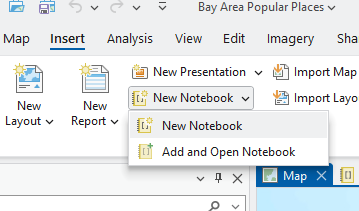

It will now be visible in a newly visible folder called `Notebooks` in the catalog pane. 

In [2]:
# Now load the relevant libraries
import arcpy  # for ArcGIS tools
import os  # for interacting with your local file directory
import pandas  # for managing tabular data

In [3]:
# and set up your local working environment
aprx = arcpy.mp.ArcGISProject("Current") # your current aprx file
default_gdb = aprx.defaultGeodatabase  # the default geodatabase of the aprx
default_folder = aprx.homeFolder  # the default folder of the aprx
arcpy.env.overwriteOutput = True  # allows ArcGIS to overwrite files
map = aprx.listMaps()[0] # specify which map you're using 
crs = map.spatialReference  # borrow the default projection from that map

print("Directory: " + default_folder)
print("Geodatabase: " + default_gdb)
print("Activated map: " + map.name)
print("Coordinate reference system: " + crs.name)

Directory: C:\Users\jlauerma\Documents\ArcGIS\Packages\Bay Area Popular Places_2c8dc1
Geodatabase: C:\Users\jlauerma\Documents\ArcGIS\Packages\Bay Area Popular Places_2c8dc1\p20\bay_area_popular_places.gdb
Activated map: Map
Coordinate reference system: NAD_1983_2011_San_Francisco_CS13_ftUS


## Aggregate the check-ins data
This section prepares the data, generates a random sampling grid, and then aggregates the check-in points to the tessellated grid. 

In [6]:
# change the projection
arcpy.management.Project(
    in_dataset=os.path.join(default_gbd, "Bay_Area_Gowalla_Check_ins",
    out_dataset=os.path.join(default_gdb, "Check_ins_Projected"),
    out_coor_system='PROJCS["NAD_1983_2011_San_Francisco_CS13_ftUS",GEOGCS["GCS_NAD_1983_2011",DATUM["D_NAD_1983_2011",SPHEROID["GRS_1980",6378137.0,298.257222101]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["False_Easting",157480.0],PARAMETER["False_Northing",78740.0],PARAMETER["Central_Meridian",-122.45],PARAMETER["Scale_Factor",1.000007],PARAMETER["Latitude_Of_Origin",37.75],UNIT["Foot_US",0.3048006096012192]]',
    transform_method="'WGS_1984_(ITRF00)_To_NAD_1983 + WGS_1984_(ITRF08)_To_NAD_1983_2011'",
    in_coor_system='PROJCS["USA_Contiguous_Albers_Equal_Area_Conic",GEOGCS["GCS_North_American_1983",DATUM["D_North_American_1983",SPHEROID["GRS_1980",6378137.0,298.257222101]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Albers"],PARAMETER["False_Easting",0.0],PARAMETER["False_Northing",0.0],PARAMETER["Central_Meridian",-96.0],PARAMETER["Standard_Parallel_1",29.5],PARAMETER["Standard_Parallel_2",45.5],PARAMETER["Latitude_Of_Origin",37.5],UNIT["Meter",1.0]]',
    preserve_shape="NO_PRESERVE_SHAPE",
    max_deviation=None,
    vertical="NO_VERTICAL"
)

<Result 'C:\\Users\\jlauerma\\Documents\\ArcGIS\\Packages\\Bay Area Popular Places_2c8dc1\\p20\\bay_area_popular_places.gdb\\Check_ins_Projected'>

In [9]:
# generate tessalation
arcpy.management.GenerateTessellation(
    Output_Feature_Class=os.path.join(default_gdb, "Hexagon_Tessellation"),
    Extent='-5850.04879141971 -198976.797763176 421456.688784994 468225.606674492 PROJCS["NAD_1983_2011_San_Francisco_CS13_ftUS",GEOGCS["GCS_NAD_1983_2011",DATUM["D_NAD_1983_2011",SPHEROID["GRS_1980",6378137.0,298.257222101]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["False_Easting",157480.0],PARAMETER["False_Northing",78740.0],PARAMETER["Central_Meridian",-122.45],PARAMETER["Scale_Factor",1.000007],PARAMETER["Latitude_Of_Origin",37.75],UNIT["Foot_US",0.3048006096012192]]',
    Shape_Type="HEXAGON",
    Size="12 SquareMiles",
    Spatial_Reference='PROJCS["NAD_1983_2011_San_Francisco_CS13_ftUS",GEOGCS["GCS_NAD_1983_2011",DATUM["D_NAD_1983_2011",SPHEROID["GRS_1980",6378137.0,298.257222101]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["False_Easting",157480.0],PARAMETER["False_Northing",78740.0],PARAMETER["Central_Meridian",-122.45],PARAMETER["Scale_Factor",1.000007],PARAMETER["Latitude_Of_Origin",37.75],UNIT["Foot_US",0.3048006096012192]];-18291200 -46449800 3048.00609601219;-100000 10000;-100000 10000;3.28083333333333E-03;0.001;0.001;IsHighPrecision',
    H3_Resolution=7
)

<Result 'C:\\Users\\jlauerma\\Documents\\ArcGIS\\Packages\\Bay Area Popular Places_2c8dc1\\p20\\bay_area_popular_places.gdb\\Hexagon_Tessellation'>

In [10]:
# select hexagons that intersect check-in points points
arcpy.management.SelectLayerByLocation(
    in_layer="Hexagon_Tessellation",
    overlap_type="INTERSECT",
    select_features="Check_ins_Projected",
    search_distance=None,
    selection_type="NEW_SELECTION",
    invert_spatial_relationship="NOT_INVERT"
)

<Result 'Hexagon_Tessellation'>

In [11]:
# spatial join hexagons with check-in points
arcpy.analysis.SpatialJoin(
    target_features="Hexagon_Tessellation",
    join_features="Check_ins_Projected",
    out_feature_class=os.path.join(default_gdb, "Check_in_Counts"),
    join_operation="JOIN_ONE_TO_ONE",
    join_type="KEEP_ALL",
    field_mapping='Shape_Length "Shape_Length" false true true 8 Double 0 0,First,#,Hexagon_Tessellation,Shape_Length,-1,-1;Shape_Area "Shape_Area" false true true 8 Double 0 0,First,#,Hexagon_Tessellation,Shape_Area,-1,-1;GRID_ID "GRID_ID" true true false 12 Text 0 0,First,#,Hexagon_Tessellation,GRID_ID,0,11;User_ID "User ID" true true false 4 Long 0 0,First,#,Check_ins_Projected,User_ID,-1,-1;Check_in_Time "Check-in Time" true true false 8000 Text 0 0,First,#,Check_ins_Projected,Check_in_Time,0,7999;Check_in_Latitude "Check-in Latitude" true true false 8 Double 0 0,First,#,Check_ins_Projected,Check_in_Latitude,-1,-1;Check_in_Longitude "Check-in Longitude" true true false 8 Double 0 0,First,#,Check_ins_Projected,Check_in_Longitude,-1,-1;Location_ID "Location ID" true true false 4 Long 0 0,First,#,Check_ins_Projected,Location_ID,-1,-1',
    match_option="INTERSECT",
    search_radius=None,
    distance_field_name="",
    match_fields=None
)

<Result 'C:\\Users\\jlauerma\\Documents\\ArcGIS\\Packages\\Bay Area Popular Places_2c8dc1\\p20\\bay_area_popular_places.gdb\\Check_in_Counts'>

## Quantify the significance of the aggregations
This section explores clustering in the data with: 
- Global Moran's I: Tests whether the data are spatially random or have some underlying clustering structure.
- Density-based clustering: This identifies clusters of similar observations based on their spatial relationships. We'll experiment with several different clustering methods used to define the search radius. 

In [12]:
# test global Moran's I on check-in counts
arcpy.stats.SpatialAutocorrelation(
    Input_Feature_Class="Check_in_Counts",
    Input_Field="Join_Count",
    Generate_Report="GENERATE_REPORT",
    Conceptualization_of_Spatial_Relationships="INVERSE_DISTANCE",
    Distance_Method="EUCLIDEAN_DISTANCE",
    Standardization="ROW",
    Distance_Band_or_Threshold_Distance=None,
    Weights_Matrix_File=None,
    number_of_neighbors=None
)

<Result '0.103374'>

Open the html report by copy/pasting the file path into any web browser. It will include a variety of interpretive metrics for assessing the relative significance of the clustering pattern. 
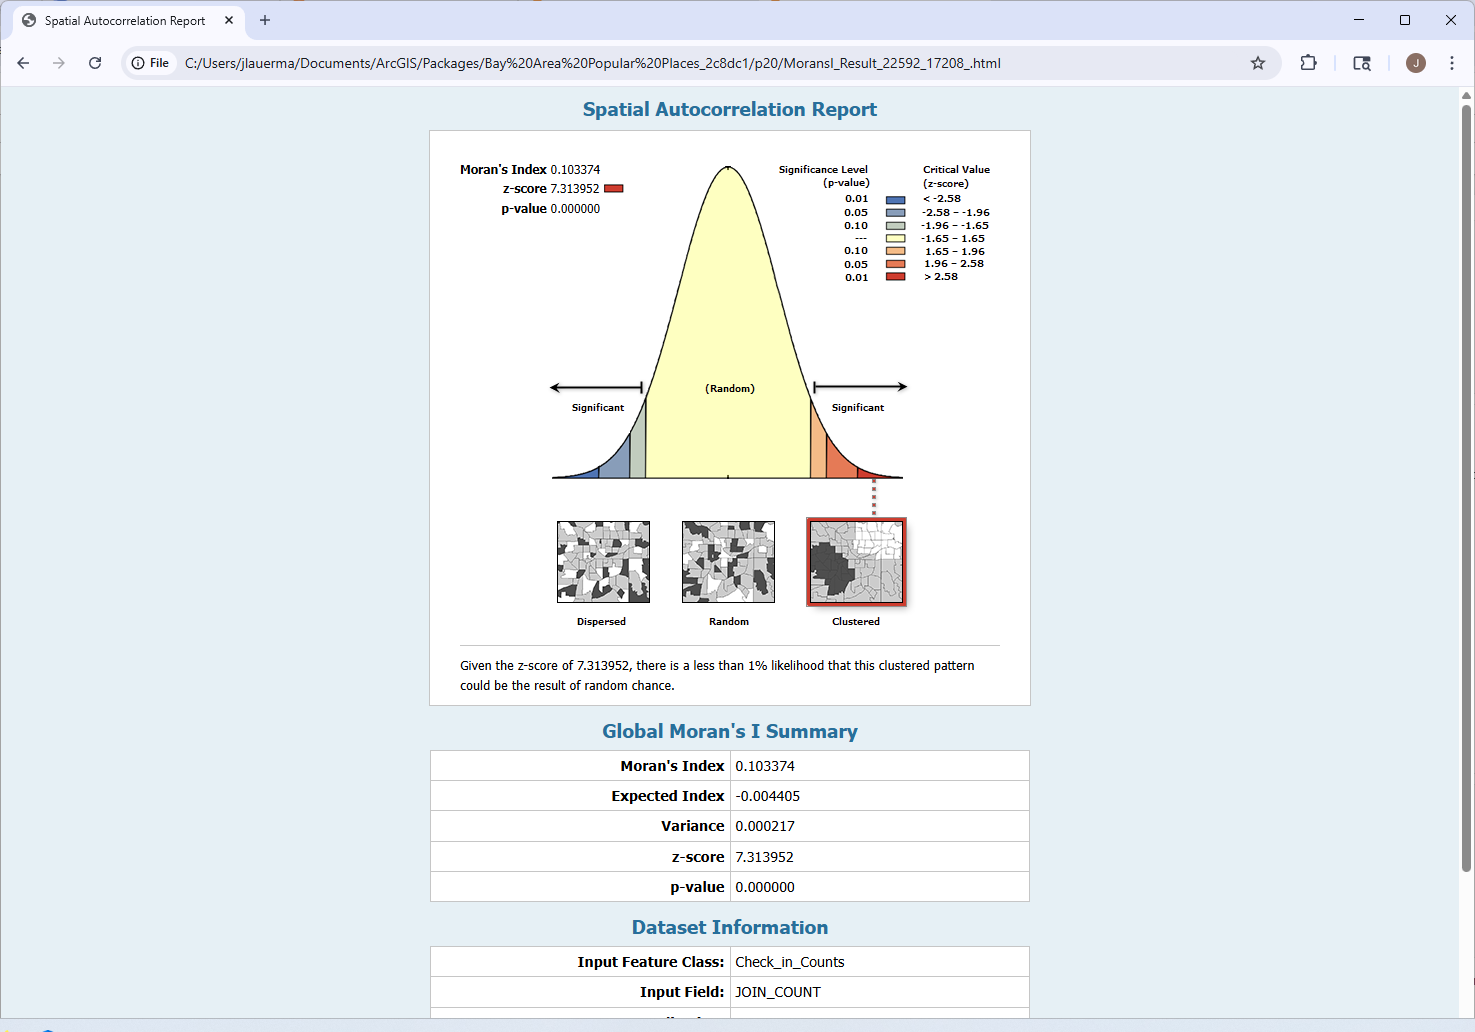

In [14]:
# density based clustering using defined distance
arcpy.stats.DensityBasedClustering(
    in_features="Check_ins_Projected",
    output_features=os.path.join(default_gdb, "DBSCAN_500"),
    cluster_method="DBSCAN",
    min_features_cluster=500,
    search_distance="0.1 Miles",
    cluster_sensitivity=None,
    time_field=None,
    search_time_interval=None
)

<Result 'C:\\Users\\jlauerma\\Documents\\ArcGIS\\Packages\\Bay Area Popular Places_2c8dc1\\p20\\bay_area_popular_places.gdb\\DBSCAN_500'>

In [15]:
# density based clustering using self adjusting distance
# note that this might take some time...
arcpy.stats.DensityBasedClustering(
    in_features="Check_ins_Projected",
    output_features=os.path.join(default_gdb, "HDBSCAN_500"),
    cluster_method="HDBSCAN",
    min_features_cluster=500,
    search_distance=None,
    cluster_sensitivity=None,
    time_field=None,
    search_time_interval=None
)

<Result 'C:\\Users\\jlauerma\\Documents\\ArcGIS\\Packages\\Bay Area Popular Places_2c8dc1\\p20\\bay_area_popular_places.gdb\\HDBSCAN_500'>

In [10]:
# density based clustering using multi-scale method
arcpy.stats.DensityBasedClustering(
    in_features="Check_ins_Projected",
    output_features=os.path.join(default_gdb, "OPTICS_500"),
    cluster_method="OPTICS",
    min_features_cluster=500,
    search_distance="0.1 Miles",
    cluster_sensitivity=None,
    time_field=None,
    search_time_interval=None
)

<Result 'C:\\Users\\jlauerma\\Documents\\ArcGIS\\Packages\\Bay Area Popular Places_2c8dc1\\p20\\bay_area_popular_places.gdb\\OPTICS_500'>

In [11]:
# and adjust the sensitivity parameter
arcpy.stats.DensityBasedClustering(
    in_features="Check_ins_Projected",
    output_features=os.path.join(default_gdb, "OPTICS_500_Sensitivity_0"),
    cluster_method="OPTICS",
    min_features_cluster=500,
    search_distance="0.1 Miles",
    cluster_sensitivity=0,
    time_field=None,
    search_time_interval=None
)

<Result 'C:\\Users\\jlauerma\\Documents\\ArcGIS\\Packages\\Bay Area Popular Places_2c8dc1\\p20\\bay_area_popular_places.gdb\\OPTICS_500_Sensitivity_0'>

## Analyze the data temporally
This section visualizes and analyzes temporal patterns, in order to identify time-series clusters.

In [16]:
# convert the date field
arcpy.management.ConvertTimeField(
    in_table=os.path.join(default_gdb, "Bay_Area_Gowalla_Check_ins"),
    input_time_field="Check_in_Time",
    input_time_format="yyyy-MM-ddTHH:mm:ssZ",
    output_time_field="Check_in_Time_Converted",
    output_time_type="DATE",
    output_time_format="",
    timezone_or_field=""
)

<Result 'C:\\Users\\jlauerma\\Documents\\ArcGIS\\Packages\\Bay Area Popular Places_2c8dc1\\p20\\bay_area_popular_places.gdb\\Bay_Area_Gowalla_Check_ins'>

In [18]:
# select by attribute
arcpy.management.SelectLayerByAttribute(
    in_layer_or_view=os.path.join(default_gdb, "Bay_Area_Gowalla_Check_ins"),
    selection_type="NEW_SELECTION",
    where_clause="Check_in_Time_Converted >= timestamp '2010-08-01 14:14:02' And Check_in_Time_Converted <= timestamp '2010-09-30 14:14:25'",
    invert_where_clause=None
)

<Result 'Bay_Area_Gowalla_Check_ins_L1'>

In [19]:
# copy to new layer
arcpy.management.CopyFeatures(
    in_features=os.path.join(default_gdb, "Bay_Area_Gowalla_Check_ins"),
    out_feature_class=os.path.join(default_gdb, "Check_ins_Aug_Sep_2010"),
    config_keyword="",
    spatial_grid_1=None,
    spatial_grid_2=None,
    spatial_grid_3=None
)

<Result 'C:\\Users\\jlauerma\\Documents\\ArcGIS\\Packages\\Bay Area Popular Places_2c8dc1\\p20\\bay_area_popular_places.gdb\\Check_ins_Aug_Sep_2010'>

In [25]:
# select by attribute again, this time with a wider time range
selection = arcpy.management.SelectLayerByAttribute(
    in_layer_or_view=os.path.join(default_gdb, "Bay_Area_Gowalla_Check_ins"),
    selection_type="NEW_SELECTION",
    where_clause="Check_in_Time_Converted >= timestamp '2009-12-01 14:14:02' And Check_in_Time_Converted <= timestamp '2010-09-30 14:14:25'",
    invert_where_clause=None
)
print(selection)

Bay_Area_Gowalla_Check_ins_L1


In [29]:
# Generate a space time cube
arcpy.stpm.CreateSpaceTimeCube(
    in_features="Bay_Area_Gowalla_Check_ins_L1",
    output_cube=os.path.join(default_folder, "Check_ins_STC.nc"),
    time_field="Check_in_Time_Converted",
    template_cube=None,
    time_step_interval=None,
    time_step_alignment="END_TIME",
    reference_time=None,
    distance_interval="1 Miles",
    summary_fields=None,
    aggregation_shape_type="HEXAGON_GRID",
    defined_polygon_locations=None,
    location_id=None
)

<Result 'C:\\Users\\jlauerma\\Documents\\ArcGIS\\Packages\\Bay Area Popular Places_2c8dc1\\Check_ins_STC.nc'>

In [31]:
# visualize the space time data in 2D
arcpy.stpm.VisualizeSpaceTimeCube2D(
    in_cube=os.path.join(default_folder, "Check_ins_STC.nc"),
    cube_variable="COUNT",
    display_theme="TRENDS",
    output_features=os.path.join(default_gdb, "Check_ins_STC_2D"),
    enable_time_series_popups="CREATE_POPUP"
)

<Result 'C:\\Users\\jlauerma\\Documents\\ArcGIS\\Packages\\Bay Area Popular Places_2c8dc1\\p20\\bay_area_popular_places.gdb\\Check_ins_STC_2D'>

In [32]:
# visualize the space time data in 3D
arcpy.stpm.VisualizeSpaceTimeCube3D(
    in_cube=os.path.join(default_folder, "Check_ins_STC.nc"),
    cube_variable="COUNT",
    display_theme="VALUE",
    output_features=os.path.join(default_gdb, "Check_ins_STC_3D")
)

<Result 'C:\\Users\\jlauerma\\Documents\\ArcGIS\\Packages\\Bay Area Popular Places_2c8dc1\\p20\\bay_area_popular_places.gdb\\Check_ins_STC_3D'>

In [34]:
# now we'll use a time series clustering algorithm 
arcpy.stpm.TimeSeriesClustering(
    in_cube=os.path.join(default_folder, "Check_ins_STC.nc"),
    analysis_variable="COUNT",
    output_features=os.path.join(default_gdb, "Check_ins_Monthly_Clusters"),
    characteristic_of_interest="VALUE",
    cluster_count=3,
    output_table_for_charts=os.path.join(default_gdb, "Clustering_Tables"),
    shape_characteristic_to_ignore=None,
    enable_time_series_popups="CREATE_POPUP"
)

<Result 'C:\\Users\\jlauerma\\Documents\\ArcGIS\\Packages\\Bay Area Popular Places_2c8dc1\\p20\\bay_area_popular_places.gdb\\Check_ins_Monthly_Clusters'>

In [37]:
# now try it with a Fourier range method
arcpy.stpm.TimeSeriesClustering(
    in_cube=os.path.join(default_folder, "Check_ins_STC.nc"),
    analysis_variable="COUNT",
    output_features=os.path.join(default_gdb, "Check_ins_Monthly_Clusters_Fourier"),
    characteristic_of_interest="PROFILE_FOURIER",
    cluster_count=3,
    output_table_for_charts=os.path.join(default_gdb, "Clustering_Tables"),
    shape_characteristic_to_ignore="RANGE",
    enable_time_series_popups="CREATE_POPUP"
)

<Result 'C:\\Users\\jlauerma\\Documents\\ArcGIS\\Packages\\Bay Area Popular Places_2c8dc1\\p20\\bay_area_popular_places.gdb\\Check_ins_Monthly_Clusters_Fourier'>

## Detect spatial and temporal hot spots
Finally, we'll identify spatio-temporal hotspots. 

In [36]:
# run emerging hot spot analysis
arcpy.stpm.EmergingHotSpotAnalysis(
    in_cube=os.path.join(default_folder, "Check_ins_STC.nc"),
    analysis_variable="COUNT",
    output_features=os.path.join(default_gdb, "Check_ins_STC_EmergingHotSpotAnalysis"),
    neighborhood_distance="1 Miles",
    neighborhood_time_step=1,
    polygon_mask=None,
    conceptualization_of_spatial_relationships="FIXED_DISTANCE",
    number_of_neighbors=None,
    define_global_window="ENTIRE_CUBE"
)

<Result 'C:\\Users\\jlauerma\\Documents\\ArcGIS\\Packages\\Bay Area Popular Places_2c8dc1\\p20\\bay_area_popular_places.gdb\\Check_ins_STC_EmergingHotSpotAnalysis'>

In [38]:
# set up queries for the relevant criteria
## walkable clusters
arcpy.management.SelectLayerByAttribute(
    in_layer_or_view="HDBSCAN_500",
    selection_type="NEW_SELECTION",
    where_clause="CLUSTER_ID <> -1",
    invert_where_clause=None
)

## intensifying and persistent hot spots
arcpy.management.SelectLayerByAttribute(
    in_layer_or_view="Check_ins_STC_EmergingHotSpotAnalysis",
    selection_type="NEW_SELECTION",
    where_clause="PATTERN IN ('Intensifying Hot Spot', 'Persistent Hot Spot')",
    invert_where_clause=None
)

## clusters in summer months
arcpy.management.SelectLayerByAttribute(
    in_layer_or_view="Check_ins_Monthly_Clusters_Fourier",
    selection_type="NEW_SELECTION",
    where_clause="CLUSTER_ID = 3",
    invert_where_clause=None
)

<Result 'Check_ins_Monthly_Clusters_Fourier'>

In [39]:
# one final intersection to find where the above queries overlap
arcpy.analysis.Intersect(
    in_features="HDBSCAN_500 #;Check_ins_STC_EmergingHotSpotAnalysis #;Check_ins_Monthly_Clusters_Fourier #",
    out_feature_class=os.path.join(default_gdb, "Ideal_Locations"),
    join_attributes="ONLY_FID",
    cluster_tolerance=None,
    output_type="INPUT"
)

<Result 'C:\\Users\\jlauerma\\Documents\\ArcGIS\\Packages\\Bay Area Popular Places_2c8dc1\\p20\\bay_area_popular_places.gdb\\Ideal_Locations'>